In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression as LR
from sklearn.decomposition import PCA
from scipy.stats import special_ortho_group as sog

from dca.cov_util import calc_cross_cov_mats_from_data
from dca.data_util import CrossValidate, form_lag_matrix
from dca.methods_comparison import SlowFeatureAnalysis as SFA
from dca import DynamicalComponentsAnalysis
from scipy.optimize import minimize

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib import pyplot as plt

In [2]:
from dca import DynamicalComponentsAnalysis
from dca.methods_comparison import JPCA
from pydmd import DMD
from scipy.io import loadmat

x = loadmat("../data/exampleData.mat")

In [3]:
class JDCA(object):
    """ jDCA. jPCA but running DCA first.

    Parameters
    ----------
    n_components : even int (default=6)
        Number of components to reduce X to.

    mean_subtract: boolean (default=True)
        Whether to subtract the cross-condition mean from each condition
        before running jPCA.

    Attributes
    ----------
    eigen_vecs_ : list
        List of numpy eigenvectors from JPCA skew symmetric matrix sorted in
        descending order by magnitude of eigenvalue.

    eigen_vals_ : list
        List of eigenvalues from JPCA skew symmetric matrix. The index
        of each eigenvalue corresponds with the eigenvector in eigen_vecs_.

    dca_ : DCA object
        DCA object used to transform X to X_red.

    cross_condition_mean_ : ndarray (time, features)
        Cross condition mean of X during fit.

    """
    def __init__(self, n_components=6, time_window=3, mean_subtract=True):
        if n_components // 2 != n_components / 2:
            raise ValueError("n_components must be even int")
        self.n_components_ = n_components
        self.mean_subtract_ = mean_subtract
        self.eigen_vecs_ = None
        self.eigen_vals_ = None
        self.dca_ = None
        self.cross_condition_mean_ = None
        self.time_window_ = time_window
        self.proj_vectors_ = None
        self.X_red = None

    def fit(self, X):
        """ Fit a jPCA model to X.

        Parameters
        ----------
        X : ndarray (conditions, time, features)
            Data to fit using jPCA model.

        Returns
        -------
        self
        """
        if self.n_components_ > X.shape[2]:
            raise ValueError("n_components is greater than number of features in X.")

        if len(X.shape) != 3:
            raise ValueError("Data must be in 3 dimensions (conditions, time, features).")

        if self.mean_subtract_:
            self.cross_condition_mean_ = np.mean(X, axis=0, keepdims=True)
            X = X - self.cross_condition_mean_

        #X_flat = np.concatenate(X, axis=0)
        self.dca_ = DynamicalComponentsAnalysis(d=self.n_components_, T=self.time_window_, n_init=5)
        self.dca_.fit(X)

        X_red = [self.dca_.transform(Xi) for Xi in X]
        dX = np.concatenate([np.diff(Xi, axis=0) for Xi in X_red], axis=0)
        X_prestate = np.concatenate([Xi[:-1] for Xi in X_red], axis=0)
        M_skew = self._fit_skew(X_prestate, dX)
        self.eigen_vals_, self.eigen_vecs_ = self._get_jpcs(M_skew)

        return self

    def transform(self, X):
        """ Transform X using JPCA components.

        Parameters
        ----------
        X : ndarray (conditions, time, features)
            Data to fit using jPCA model.

        Returns
        -------
        ndarray (conditions, time, n_components)
            X projected onto jPCA components (conditions are preserved).
            In X_proj, every pair of features correspond to a conjugate pair
            of JPCA eigenvectors. The pairs are sorted by largest magnitude eigenvalue
            (i.e. dimensions 0 and 1 in X_proj contains the projection from
            the conjugate eigenvector pair with the largest eigenvalue magnitude).
            The projection pair is what captures the rotations.

        """

        if self.mean_subtract_:
            X = X - self.cross_condition_mean_

        X_red = [self.dca_.transform(Xi) for Xi in X]
        self.X_red = X_red
        proj_vectors = []
        for i in range(len(self.eigen_vecs_) // 2):
            v1 = self.eigen_vecs_[2*i]
            v2 = self.eigen_vecs_[2*i + 1]
            
            real_v1 = np.real(v1 + v2)
            
            real_v1 /= np.linalg.norm(real_v1)
            real_v2 = np.imag((v1 - v2))
            real_v2 /= np.linalg.norm(real_v2)
            
            # remove 0j
            proj_vectors.append(real_v1)
            proj_vectors.append(real_v2)
        self.proj_vectors_ = proj_vectors
        X_proj = np.stack([X_redi @ np.array(proj_vectors).T for X_redi in X_red], axis=0)
        return X_proj

    def fit_transform(self, X):
        """ Fit and transform X using JPCA.

        Parameters
        ----------
        X : ndarray (conditions, time, features)
            Data to be transformed by JPCA.

        Returns
        -------
        ndarray (conditions*time, n_components)
            X projected onto JPCA components.
        """
        self.fit(X)
        return self.transform(X)

    def _fit_skew(self, X_prestate, dX):
        """
        Assume the differential equation dX = M * X_prestate. This function will return
        M_skew, the skew symmetric component of M, that best fits the data. dX and
        X_prestate should be the same shape.
        Note: M is solved for using least squares.

        Parameters
        ----------
        X_prestate : np.array
            Time series matrix with the last time step removed.

        dX : np.array
            Discrete derivative matrix of X obtained by subtracting each row with its
            previous time step. (derivative at time 0 is not included).

        Returns
        -------
        M_skew : np.array
            Optimal skew symmetric matrix that best fits dX and X_prestate.

        """
        # guaranteed to be square
        M0, _, _, _ = np.linalg.lstsq(X_prestate, dX, rcond=None)
        M0_skew = .5 * (M0 - M0.T)
        m_skew = self._mat2vec(M0_skew)
        opt = self._optimize_skew(m_skew, X_prestate, dX)
        return self._vec2mat(opt.x)

    def _optimize_skew(self, m_skew, X_prestate, dX):
        """
        Solves for M_skew using gradient optimization methods.
        The objective function and derivative equations have closed forms.

        Parameters
        ----------
        m_skew : np.array
            Flattened array (1d vector) of initial M_skew guess

        X_prestate : np.array
            Time series matrix with the last time step removed.

        dX : np.array
            Discrete derivative matrix of X obtained by subtracting each row with its
            previous time step. (derivative at time 0 is not included).

        Returns
        -------
        opt : scipy.OptimizeResult object
            SciPy optimization result.
        """
        def objective(x, X_prestate, dX):
            f = np.linalg.norm(dX - X_prestate@self._vec2mat(x))
            return f**2

        def derivative(x, X_prestate, dX):
            D = dX - X_prestate @ self._vec2mat(x)
            D = D.T @ X_prestate
            return 2 * self._mat2vec(D - D.T)

        return minimize(objective, m_skew, jac=derivative, args=(X_prestate, dX))

    def _get_jpcs(self, M_skew):
        """
        Given optimal M_skew matrix, return the eigenvalues and eigenvectors
        of M_skew. The eigenvectors/values are sorted by eigenvalue magnitude.

        Parameters
        ----------
        M_skew : np.array
            optimal M_skew (2D matrix)

        Returns
        -------
        evecs : np.array
            2D Array where each row is a jPC.

        evals : np.array of floats
            Array where each position contains the correpsonding eigenvalue to the
            jPC in evecs.
        """
        evals, evecs = np.linalg.eig(M_skew)
        evecs = evecs.T
        # get rid of small real number
        evals_j = np.imag(evals)

        # sort in descending order
        sort_indices = np.argsort(-np.absolute(evals_j))
        return evals_j[sort_indices], evecs[sort_indices]

    def _mat2vec(self, mat):
        """
        Convert 2D array into flattened array in column major order.

        Parameters
        ----------
        mat : ndarray (num_rows, num_cols)
            2D matrix to be flattened.

        Returns:
            1D ndarray of size (num_rows*num_cols)
        """
        return mat.flatten('F')

    def _vec2mat(self, vec):
        """
        Convert flattened vector into 2D matrix in column major order.

        Parameters
        ----------
        vec : 1D ndarray (num_rows*num_cols, 1)
            Flattened array to be reshaped into 2D square ndarray.

        Returns
        -------
            2D ndarray (num_rows, num_cols)
        """
        shape = (int(vec.size**(.5)), -1)
        return np.reshape(vec, shape, 'F')

In [4]:
class JDMD(object):
    """ jDMD. jPCA but running DMD first.

    Parameters
    ----------
    n_components : even int (default=6)
        Number of components to reduce X to.

    mean_subtract: boolean (default=True)
        Whether to subtract the cross-condition mean from each condition
        before running jPCA.

    Attributes
    ----------
    eigen_vecs_ : list
        List of numpy eigenvectors from JPCA skew symmetric matrix sorted in
        descending order by magnitude of eigenvalue.

    eigen_vals_ : list
        List of eigenvalues from JPCA skew symmetric matrix. The index
        of each eigenvalue corresponds with the eigenvector in eigen_vecs_.

    dmd_ : DMD object
        DMD object used to transform X to X_red.

    cross_condition_mean_ : ndarray (time, features)
        Cross condition mean of X during fit.

    """
    def __init__(self, n_components=6, mean_subtract=True):
        if n_components // 2 != n_components / 2:
            raise ValueError("n_components must be even int")
        self.n_components_ = n_components
        self.mean_subtract_ = mean_subtract
        self.eigen_vecs_ = None
        self.eigen_vals_ = None
        self.dmd_ = None
        self.cross_condition_mean_ = None

    def fit(self, X):
        """ Fit a jPCA model to X.

        Parameters
        ----------
        X : ndarray (conditions, time, features)
            Data to fit using jPCA model.

        Returns
        -------
        self
        """
        if self.n_components_ > X.shape[2]:
            raise ValueError("n_components is greater than number of features in X.")

        if len(X.shape) != 3:
            raise ValueError("Data must be in 3 dimensions (conditions, time, features).")

        if self.mean_subtract_:
            self.cross_condition_mean_ = np.mean(X, axis=0, keepdims=True)
            X = X - self.cross_condition_mean_

        X_flat = np.concatenate(X, axis=0)
        self.dmd_ = DMD(svd_rank=self.n_components_)
        self.dmd_.fit(X_flat.T)

        X_red = [Xi @ self.dmd_._modes for Xi in X]
        dX = np.concatenate([np.diff(Xi, axis=0) for Xi in X_red], axis=0)
        X_prestate = np.concatenate([Xi[:-1] for Xi in X_red], axis=0)
        M_skew = self._fit_skew(X_prestate, dX)
        self.eigen_vals_, self.eigen_vecs_ = self._get_jpcs(M_skew)

        return self

    def transform(self, X):
        """ Transform X using JPCA components.

        Parameters
        ----------
        X : ndarray (conditions, time, features)
            Data to fit using jPCA model.

        Returns
        -------
        ndarray (conditions, time, n_components)
            X projected onto jPCA components (conditions are preserved).
            In X_proj, every pair of features correspond to a conjugate pair
            of JPCA eigenvectors. The pairs are sorted by largest magnitude eigenvalue
            (i.e. dimensions 0 and 1 in X_proj contains the projection from
            the conjugate eigenvector pair with the largest eigenvalue magnitude).
            The projection pair is what captures the rotations.

        """

        if self.mean_subtract_:
            X = X - self.cross_condition_mean_

        X_red = [Xi @ self.dmd_._modes for Xi in X]

        proj_vectors = []
        for i in range(len(self.eigen_vecs_) // 2):
            v1 = self.eigen_vecs_[2*i]
            v2 = self.eigen_vecs_[2*i + 1]
            
            real_v1 = np.real(v1 + v2)
            
            real_v1 /= np.linalg.norm(real_v1)
            real_v2 = np.imag((v1 - v2))
            real_v2 /= np.linalg.norm(real_v2)
            
            # remove 0j
            proj_vectors.append(real_v1)
            proj_vectors.append(real_v2)
        X_proj = np.stack([X_redi @ np.array(proj_vectors).T for X_redi in X_red], axis=0)
        return X_proj

    def fit_transform(self, X):
        """ Fit and transform X using JPCA.

        Parameters
        ----------
        X : ndarray (conditions, time, features)
            Data to be transformed by JPCA.

        Returns
        -------
        ndarray (conditions*time, n_components)
            X projected onto JPCA components.
        """
        self.fit(X)
        return self.transform(X)

    def _fit_skew(self, X_prestate, dX):
        """
        Assume the differential equation dX = M * X_prestate. This function will return
        M_skew, the skew symmetric component of M, that best fits the data. dX and
        X_prestate should be the same shape.
        Note: M is solved for using least squares.

        Parameters
        ----------
        X_prestate : np.array
            Time series matrix with the last time step removed.

        dX : np.array
            Discrete derivative matrix of X obtained by subtracting each row with its
            previous time step. (derivative at time 0 is not included).

        Returns
        -------
        M_skew : np.array
            Optimal skew symmetric matrix that best fits dX and X_prestate.

        """
        # guaranteed to be square
        M0, _, _, _ = np.linalg.lstsq(X_prestate, dX, rcond=None)
        M0_skew = .5 * (M0 - M0.T)
        m_skew = self._mat2vec(M0_skew)
        opt = self._optimize_skew(m_skew, X_prestate, dX)
        return self._vec2mat(opt.x)

    def _optimize_skew(self, m_skew, X_prestate, dX):
        """
        Solves for M_skew using gradient optimization methods.
        The objective function and derivative equations have closed forms.

        Parameters
        ----------
        m_skew : np.array
            Flattened array (1d vector) of initial M_skew guess

        X_prestate : np.array
            Time series matrix with the last time step removed.

        dX : np.array
            Discrete derivative matrix of X obtained by subtracting each row with its
            previous time step. (derivative at time 0 is not included).

        Returns
        -------
        opt : scipy.OptimizeResult object
            SciPy optimization result.
        """
        def objective(x, X_prestate, dX):
            f = np.linalg.norm(dX - X_prestate@self._vec2mat(x))
            return f**2

        def derivative(x, X_prestate, dX):
            D = dX - X_prestate @ self._vec2mat(x)
            D = D.T @ X_prestate
            return 2 * self._mat2vec(D - D.T)

        return minimize(objective, m_skew, jac=derivative, args=(X_prestate, dX))

    def _get_jpcs(self, M_skew):
        """
        Given optimal M_skew matrix, return the eigenvalues and eigenvectors
        of M_skew. The eigenvectors/values are sorted by eigenvalue magnitude.

        Parameters
        ----------
        M_skew : np.array
            optimal M_skew (2D matrix)

        Returns
        -------
        evecs : np.array
            2D Array where each row is a jPC.

        evals : np.array of floats
            Array where each position contains the correpsonding eigenvalue to the
            jPC in evecs.
        """
        evals, evecs = np.linalg.eig(M_skew)
        evecs = evecs.T
        # get rid of small real number
        evals_j = np.imag(evals)

        # sort in descending order
        sort_indices = np.argsort(-np.absolute(evals_j))
        return evals_j[sort_indices], evecs[sort_indices]

    def _mat2vec(self, mat):
        """
        Convert 2D array into flattened array in column major order.

        Parameters
        ----------
        mat : ndarray (num_rows, num_cols)
            2D matrix to be flattened.

        Returns:
            1D ndarray of size (num_rows*num_cols)
        """
        return mat.flatten('F')

    def _vec2mat(self, vec):
        """
        Convert flattened vector into 2D matrix in column major order.

        Parameters
        ----------
        vec : 1D ndarray (num_rows*num_cols, 1)
            Flattened array to be reshaped into 2D square ndarray.

        Returns
        -------
            2D ndarray (num_rows, num_cols)
        """
        shape = (int(vec.size**(.5)), -1)
        return np.reshape(vec, shape, 'F')

In [15]:
def linear_decode_r2(X_train, Y_train, X_test, Y_test, decoding_window=1, offset=0):
    """Train a linear model on the training set and test on the test set.
    This will work with batched training data and/or batched test data.
    """

    if isinstance(X_train, np.ndarray) and X_train.ndim == 2:
        X_train = [X_train]
    if isinstance(Y_train, np.ndarray) and Y_train.ndim == 2:
        Y_train = [Y_train]

    if isinstance(X_test, np.ndarray) and X_test.ndim == 2:
        X_test = [X_test]
    if isinstance(Y_test, np.ndarray) and Y_test.ndim == 2:
        Y_test = [Y_test]

    X_train_lags = [form_lag_matrix(Xi, decoding_window) for Xi in X_train]
    X_test_lags = [form_lag_matrix(Xi, decoding_window) for Xi in X_test]

    Y_train = [Yi[decoding_window // 2:] for Yi in Y_train]
    Y_train = [Yi[:len(Xi)] for Yi, Xi in zip(Y_train, X_train_lags)]
    if offset >= 0:
        Y_train = [Yi[offset:] for Yi in Y_train]
    else:
        Y_train = [Yi[:Yi.shape[0] + offset] for Yi in Y_train]

    Y_test = [Yi[decoding_window // 2:] for Yi in Y_test]
    Y_test = [Yi[:len(Xi)] for Yi, Xi in zip(Y_test, X_test_lags)]
    if offset >= 0:
        Y_test = [Yi[offset:] for Yi in Y_test]
    else:
        Y_test = [Yi[:Yi.shape[0] + offset] for Yi in Y_test]

    if offset >= 0:
        X_train_lags = [Xi[:Xi.shape[0] - offset] for Xi in X_train_lags]
        X_test_lags = [Xi[:Xi.shape[0] - offset] for Xi in X_test_lags]
    else:
        X_train_lags = [Xi[-offset:] for Xi in X_train_lags]
        X_test_lags = [Xi[-offset:] for Xi in X_test_lags]

    if len(X_train_lags) == 1:
        X_train_lags = X_train_lags[0]
    else:
        X_train_lags = np.concatenate(X_train_lags)

    if len(Y_train) == 1:
        Y_train = Y_train[0]
    else:
        Y_train = np.concatenate(Y_train)

    if len(X_test_lags) == 1:
        X_test_lags = X_test_lags[0]
    else:
        X_test_lags = np.concatenate(X_test_lags)

    if len(Y_test) == 1:
        Y_test = Y_test[0]
    else:
        Y_test = np.concatenate(Y_test)

    model = LR().fit(X_train_lags, Y_train)
    r2 = model.score(X_test_lags, Y_test)
    return r2


def compare_methods_r2(X_train, Y_train, X_test, Y_test, d=2, decoding_window=1, offset=1, mean_subtract=False):
    X_mean = np.concatenate(X_train).mean(axis=0, keepdims=True)
    X_train_ctd = np.array([Xi - X_mean for Xi in X_train])
    X_test_ctd = X_test - X_mean
    Y_mean = np.concatenate(Y_train).mean(axis=0, keepdims=True)
    Y_train_ctd = np.array([Yi - Y_mean for Yi in Y_train])
    Y_test_ctd = Y_test - Y_mean
    
    # Initiate methods
    jpca = JPCA(n_components=d, mean_subtract=mean_subtract)
    dca = DynamicalComponentsAnalysis(d=d, T=3, n_init=5)
    dmd = DMD(svd_rank=d)
    pca = PCA(n_components=d)
    
    jdca = JDCA(n_components=d, mean_subtract=mean_subtract)
    jdmd = JDMD(n_components=d, mean_subtract=mean_subtract)
    
    # Run methods on training data
    pca.fit(np.vstack(X_train_ctd))
    jpca.fit(X_train_ctd)
    dca.fit(X_train_ctd)
    # dmd uses columns as features
    dmd.fit(np.vstack(X_train_ctd).T)
    
    jdca.fit(X_train_ctd)
    jdmd.fit(X_train_ctd)
    
    # Transform data with fit models
    
    X_train_pca = [pca.transform(Xi) for Xi in X_train_ctd]
    X_test_pca = [pca.transform(Xi) for Xi in X_test_ctd]
    
    X_train_jpca = jpca.transform(X_train_ctd)
    X_test_jpca = jpca.transform(X_test_ctd)
    
    X_train_dca = dca.transform(X_train_ctd)
    X_test_dca = dca.transform(X_test_ctd)
    
    X_train_dmd = X_train_ctd @ dmd._modes
    X_test_dmd = X_test_ctd @ dmd._modes
    
    X_train_jdca = jdca.transform(X_train_ctd)
    X_test_jdca = jdca.transform(X_test_ctd)
    
    X_train_jdmd = jdmd.transform(X_train_ctd)
    X_test_jdmd = jdmd.transform(X_test_ctd)
    
    pca_score = linear_decode_r2(X_train_pca, Y_train_ctd, X_test_pca, Y_test_ctd, 
                                 decoding_window=decoding_window,
                                 offset=offset)
    jpca_score = linear_decode_r2(X_train_jpca, Y_train_ctd, X_test_jpca, Y_test_ctd, 
                                 decoding_window=decoding_window,
                                 offset=offset)
    dca_score = linear_decode_r2(X_train_dca, Y_train_ctd, X_test_dca, Y_test_ctd, 
                                 decoding_window=decoding_window,
                                 offset=offset)
    dmd_score = linear_decode_r2(X_train_dmd, Y_train_ctd, X_test_dmd, Y_test_ctd, 
                                 decoding_window=decoding_window,
                                 offset=offset)
    
    jdca_score = linear_decode_r2(X_train_jdca, Y_train_ctd, X_test_jdca, Y_test_ctd, 
                                 decoding_window=decoding_window,
                                 offset=offset)
    
    jdmd_score = linear_decode_r2(X_train_jdmd, Y_train_ctd, X_test_jdmd, Y_test_ctd, 
                                 decoding_window=decoding_window,
                                 offset=offset)
    return pca_score, jpca_score, dca_score, dmd_score, jdca_score, jdmd_score
    

In [16]:
X = x['Data']
X = X.flatten()
# leave a third for testing
def split_train_test(X):
    test_train_identifier = np.random.choice(2, 108, p=[.67, .33])

    conditions_train = []
    time_train = []

    conditions_test = []
    time_test = []

    for i in range(108):
        if test_train_identifier[i] == 0:
            conditions_train.append(X[i][0])
            time_test.append(X[i][1])
        else:
            conditions_test.append(X[i][0])
            time_test.append(X[i][1])
    return np.array(conditions_train), np.array(conditions_test)

In [17]:
%%capture --no-display

offsets = [i*5 for i in range(1, 10)]
pca_scores = []
jpca_scores = []
dca_scores = []
dmd_scores = []
jdca_scores = []
jdmd_scores = []

for offset in offsets:
    conditions_train, conditions_test = split_train_test(X)
    pca_score, jpca_score, dca_score, dmd_score, jdca_score, jdmd_score = compare_methods_r2(conditions_train,
                                                                     conditions_train,
                                                                     conditions_test,
                                                                     conditions_test,
                                                                     d=2,
                                                                     offset=offset)
    pca_scores.append(pca_score)
    jpca_scores.append(jpca_score)
    dca_scores.append(dca_score)
    dmd_scores.append(dmd_score)
    jdca_scores.append(jdca_score)
    jdmd_scores.append(jdmd_score)

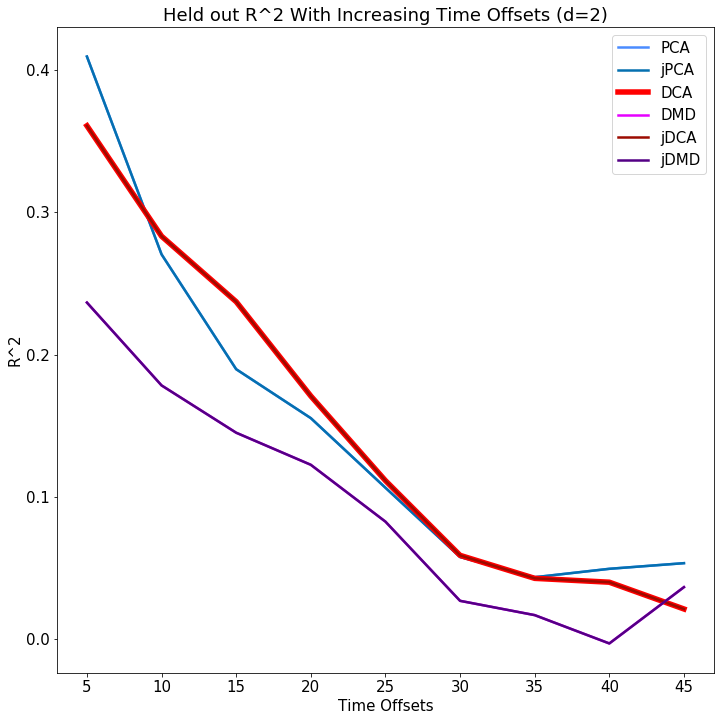

In [18]:
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 15})

plt.plot(offsets, pca_scores, label="PCA", c="#4a8cff", linewidth=2.5)
plt.plot(offsets, jpca_scores, label="jPCA", c="#0570b0", linewidth=2.5)
plt.plot(offsets, dca_scores, label="DCA", c="red", linewidth=5.5)
plt.plot(offsets, dmd_scores, label="DMD", c="#e600ff", linewidth=2.5)
plt.plot(offsets, jdca_scores, label="jDCA", c="#9c0b00", linewidth=2.5)
plt.plot(offsets, jdmd_scores, label="jDMD", c="#540085", linewidth=2.5)

plt.title("Held out R^2 With Increasing Time Offsets (d=2)")
plt.legend()
plt.tight_layout()
plt.ylabel("R^2")
plt.xlabel("Time Offsets")
plt.show()

Just making sure that the lines overlap now if I just run the j step after.

In [26]:
def linear_decode_r2(X_train, Y_train, X_test, Y_test, decoding_window=1, offset=0):
    """Train a linear model on the training set and test on the test set.
    This will work with batched training data and/or batched test data.
    """

    if isinstance(X_train, np.ndarray) and X_train.ndim == 2:
        X_train = [X_train]
    if isinstance(Y_train, np.ndarray) and Y_train.ndim == 2:
        Y_train = [Y_train]

    if isinstance(X_test, np.ndarray) and X_test.ndim == 2:
        X_test = [X_test]
    if isinstance(Y_test, np.ndarray) and Y_test.ndim == 2:
        Y_test = [Y_test]

    X_train_lags = [form_lag_matrix(Xi, decoding_window) for Xi in X_train]
    X_test_lags = [form_lag_matrix(Xi, decoding_window) for Xi in X_test]

    Y_train = [Yi[decoding_window // 2:] for Yi in Y_train]
    Y_train = [Yi[:len(Xi)] for Yi, Xi in zip(Y_train, X_train_lags)]
    if offset >= 0:
        Y_train = [Yi[offset:] for Yi in Y_train]
    else:
        Y_train = [Yi[:Yi.shape[0] + offset] for Yi in Y_train]

    Y_test = [Yi[decoding_window // 2:] for Yi in Y_test]
    Y_test = [Yi[:len(Xi)] for Yi, Xi in zip(Y_test, X_test_lags)]
    if offset >= 0:
        Y_test = [Yi[offset:] for Yi in Y_test]
    else:
        Y_test = [Yi[:Yi.shape[0] + offset] for Yi in Y_test]

    if offset >= 0:
        X_train_lags = [Xi[:Xi.shape[0] - offset] for Xi in X_train_lags]
        X_test_lags = [Xi[:Xi.shape[0] - offset] for Xi in X_test_lags]
    else:
        X_train_lags = [Xi[-offset:] for Xi in X_train_lags]
        X_test_lags = [Xi[-offset:] for Xi in X_test_lags]

    if len(X_train_lags) == 1:
        X_train_lags = X_train_lags[0]
    else:
        X_train_lags = np.concatenate(X_train_lags)

    if len(Y_train) == 1:
        Y_train = Y_train[0]
    else:
        Y_train = np.concatenate(Y_train)

    if len(X_test_lags) == 1:
        X_test_lags = X_test_lags[0]
    else:
        X_test_lags = np.concatenate(X_test_lags)

    if len(Y_test) == 1:
        Y_test = Y_test[0]
    else:
        Y_test = np.concatenate(Y_test)

    model = LR().fit(X_train_lags, Y_train)
    r2 = model.score(X_test_lags, Y_test)
    return r2


def compare_methods_r2(X_train, Y_train, X_test, Y_test, d=2, j_d = 6, decoding_window=1, offset=1, mean_subtract=False):
    
    assert j_d > d
    
    X_mean = np.concatenate(X_train).mean(axis=0, keepdims=True)
    X_train_ctd = np.array([Xi - X_mean for Xi in X_train])
    X_test_ctd = X_test - X_mean
    Y_mean = np.concatenate(Y_train).mean(axis=0, keepdims=True)
    Y_train_ctd = np.array([Yi - Y_mean for Yi in Y_train])
    Y_test_ctd = Y_test - Y_mean
    
    # Initiate methods
    dca = DynamicalComponentsAnalysis(d=d, T=3, n_init=5)
    dmd = DMD(svd_rank=d)
    pca = PCA(n_components=d)
    
    jpca = JPCA(n_components=j_d, mean_subtract=mean_subtract)
    jdca = JDCA(n_components=j_d, mean_subtract=mean_subtract)
    jdmd = JDMD(n_components=j_d, mean_subtract=mean_subtract)
    
    # Run methods on training data
    pca.fit(np.vstack(X_train_ctd))
    dca.fit(X_train_ctd)
    # dmd uses columns as features
    dmd.fit(np.vstack(X_train_ctd).T)
    
    jpca.fit(X_train_ctd)
    jdca.fit(X_train_ctd)
    jdmd.fit(X_train_ctd)
    
    # Transform data with fit models
    
    X_train_pca = [pca.transform(Xi) for Xi in X_train_ctd]
    X_test_pca = [pca.transform(Xi) for Xi in X_test_ctd]
    
    X_train_jpca = jpca.transform(X_train_ctd)[:, :, :d]    
    X_test_jpca = jpca.transform(X_test_ctd)[:, :, :d]
    print(X_train_jpca.shape)
    
    X_train_dca = dca.transform(X_train_ctd)
    X_test_dca = dca.transform(X_test_ctd)
    
    X_train_dmd = X_train_ctd @ dmd._modes
    X_test_dmd = X_test_ctd @ dmd._modes
    
    X_train_jdca = jdca.transform(X_train_ctd)[:, :, :d]
    X_test_jdca = jdca.transform(X_test_ctd)[:, :, :d]
    
    X_train_jdmd = jdmd.transform(X_train_ctd)[:, :, :d]
    X_test_jdmd = jdmd.transform(X_test_ctd)[:, :, :d]
    
    pca_score = linear_decode_r2(X_train_pca, Y_train_ctd, X_test_pca, Y_test_ctd, 
                                 decoding_window=decoding_window,
                                 offset=offset)
    jpca_score = linear_decode_r2(X_train_jpca, Y_train_ctd, X_test_jpca, Y_test_ctd, 
                                 decoding_window=decoding_window,
                                 offset=offset)
    dca_score = linear_decode_r2(X_train_dca, Y_train_ctd, X_test_dca, Y_test_ctd, 
                                 decoding_window=decoding_window,
                                 offset=offset)
    dmd_score = linear_decode_r2(X_train_dmd, Y_train_ctd, X_test_dmd, Y_test_ctd, 
                                 decoding_window=decoding_window,
                                 offset=offset)
    
    jdca_score = linear_decode_r2(X_train_jdca, Y_train_ctd, X_test_jdca, Y_test_ctd, 
                                 decoding_window=decoding_window,
                                 offset=offset)
    
    jdmd_score = linear_decode_r2(X_train_jdmd, Y_train_ctd, X_test_jdmd, Y_test_ctd, 
                                 decoding_window=decoding_window,
                                 offset=offset)
    return pca_score, jpca_score, dca_score, dmd_score, jdca_score, jdmd_score
    

In [48]:
%%capture --no-display

offsets = [i*5 for i in range(1, 10)]
pca_scores = []
jpca_scores = []
dca_scores = []
dmd_scores = []
jdca_scores = []
jdmd_scores = []

for offset in offsets:
    conditions_train, conditions_test = split_train_test(X)
    pca_score, jpca_score, dca_score, dmd_score, jdca_score, jdmd_score = compare_methods_r2(conditions_train,
                                                                     conditions_train,
                                                                     conditions_test,
                                                                     conditions_test,
                                                                     d=2,
                                                                     j_d=6,
                                                                     offset=offset)
    pca_scores.append(pca_score)
    jpca_scores.append(jpca_score)
    dca_scores.append(dca_score)
    dmd_scores.append(dmd_score)
    jdca_scores.append(jdca_score)
    jdmd_scores.append(jdmd_score)

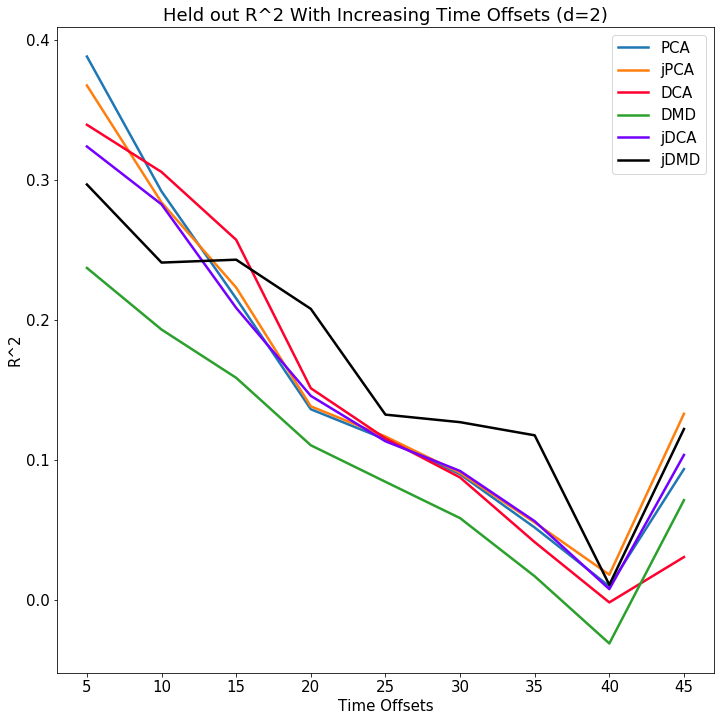

In [49]:
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 15})

plt.plot(offsets, pca_scores, label="PCA", linewidth=2.5)
plt.plot(offsets, jpca_scores, label="jPCA",linewidth=2.5)
plt.plot(offsets, dca_scores, label="DCA", c= "#ff002f", linewidth=2.5)
plt.plot(offsets, dmd_scores, label="DMD", linewidth=2.5)
plt.plot(offsets, jdca_scores, label="jDCA",  c="#7300ff", linewidth=2.5)
plt.plot(offsets, jdmd_scores, label="jDMD",  c="#000000", linewidth=2.5)

plt.title("Held out R^2 With Increasing Time Offsets (d=2)")
plt.legend()
plt.tight_layout()
plt.ylabel("R^2")
plt.xlabel("Time Offsets")
plt.show()

1. Fix jDMD/ push changes
2. Visualize DMD
3. Proper methods comparison down to 2
4. JPCA centering (across condition or across time or across time and conditions)

In [46]:
%%capture --no-display

offsets = [i*5 for i in range(1, 10)]
pca_scores = []
jpca_scores = []
dca_scores = []
dmd_scores = []
jdca_scores = []
jdmd_scores = []

for offset in offsets:
    conditions_train, conditions_test = split_train_test(X)
    pca_score, jpca_score, dca_score, dmd_score, jdca_score, jdmd_score = compare_methods_r2(conditions_train,
                                                                     conditions_train,
                                                                     conditions_test,
                                                                     conditions_test,
                                                                     d=6,
                                                                     j_d=12,
                                                                     offset=offset)
    pca_scores.append(pca_score)
    jpca_scores.append(jpca_score)
    dca_scores.append(dca_score)
    dmd_scores.append(dmd_score)
    jdca_scores.append(jdca_score)
    jdmd_scores.append(jdmd_score)

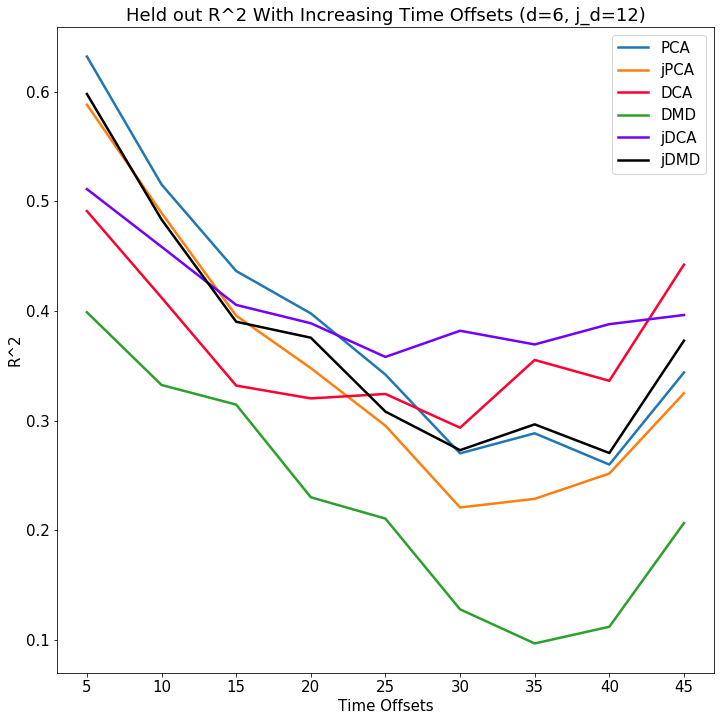

In [47]:
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 15})

plt.plot(offsets, pca_scores, label="PCA", linewidth=2.5)
plt.plot(offsets, jpca_scores, label="jPCA",linewidth=2.5)
plt.plot(offsets, dca_scores, label="DCA", c= "#ff002f", linewidth=2.5)
plt.plot(offsets, dmd_scores, label="DMD", linewidth=2.5)
plt.plot(offsets, jdca_scores, label="jDCA",  c="#7300ff", linewidth=2.5)
plt.plot(offsets, jdmd_scores, label="jDMD",  c="#000000", linewidth=2.5)

plt.title("Held out R^2 With Increasing Time Offsets (d=6, j_d=12)")
plt.legend()
plt.tight_layout()
plt.ylabel("R^2")
plt.xlabel("Time Offsets")
plt.show()

In [33]:
%%capture --no-display

offsets = [i*5 for i in range(1, 10)]
pca_scores = []
jpca_scores = []
dca_scores = []
dmd_scores = []
jdca_scores = []
jdmd_scores = []

for offset in offsets:
    conditions_train, conditions_test = split_train_test(X)
    pca_score, jpca_score, dca_score, dmd_score, jdca_score, jdmd_score = compare_methods_r2(conditions_train,
                                                                     conditions_train,
                                                                     conditions_test,
                                                                     conditions_test,
                                                                     d=20,
                                                                     j_d=40,
                                                                     offset=offset)
    pca_scores.append(pca_score)
    jpca_scores.append(jpca_score)
    dca_scores.append(dca_score)
    dmd_scores.append(dmd_score)
    jdca_scores.append(jdca_score)
    jdmd_scores.append(jdmd_score)

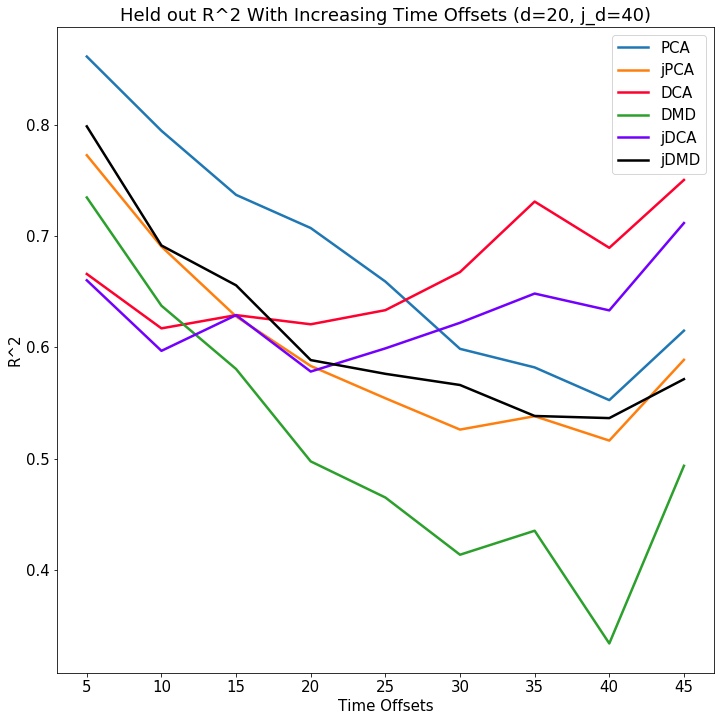

In [45]:
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 15})

plt.plot(offsets, pca_scores, label="PCA", linewidth=2.5)
plt.plot(offsets, jpca_scores, label="jPCA",linewidth=2.5)
plt.plot(offsets, dca_scores, label="DCA", c= "#ff002f", linewidth=2.5)
plt.plot(offsets, dmd_scores, label="DMD", linewidth=2.5)
plt.plot(offsets, jdca_scores, label="jDCA",  c="#7300ff", linewidth=2.5)
plt.plot(offsets, jdmd_scores, label="jDMD",  c="#000000", linewidth=2.5)

plt.title("Held out R^2 With Increasing Time Offsets (d=20, j_d=40)")
plt.legend()
plt.tight_layout()
plt.ylabel("R^2")
plt.xlabel("Time Offsets")
plt.show()